## <center> Packages & Connection </center>

In [3]:
import h3 as h3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from pyhive import presto
from keplergl import KeplerGl
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')


In [4]:
## Connection
connection = presto.connect(
        host='presto-gateway.serving.data.production.internal',
        port=80,
        protocol='http',
        catalog='hive',
        username='manoj.ravirajan@rapido.bike'
)

## <center> Local extracted files </center>

In [5]:
## Read back csv

raw_fare_estimates_enriched = pd.read_csv('local_dataset/raw_fare_estimates_enriched_10to16.csv')
raw_fare_estimates_enriched.shape

(15107691, 7)

In [6]:
raw_order_logs_immutable = pd.read_csv('local_dataset/raw_order_logs_immutable_10to16.csv')
raw_order_logs_immutable.shape

(3465515, 14)

In [7]:
raw_iallocator_customer_segments = pd.read_csv('local_dataset/raw_iallocator_customer_segments_10to16.csv')
raw_iallocator_customer_segments.shape

(14739326, 15)

In [8]:
df_fee_data = raw_fare_estimates_enriched.copy(deep=True)
print(df_fee_data.shape)
df_fee_data.head(2)

(15107691, 7)


,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,customer_id,fare_estimate_id
0,20230710,Bangalore,Auto,Neelasandra,88618925a1fffff,59c3ea60eb41616737abc8a4,64ac044f9080515d7f54de2e
1,20230710,Bangalore,Auto,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6


In [9]:
df_oli_data = raw_order_logs_immutable.copy(deep=True)
print(df_oli_data.shape)
df_oli_data.head(2)

(3465515, 14)


,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
0,20230710,Bangalore,Link,Banashankri,88618924abfffff,64aba623dff66cdf7c5e35eb,1,1,0,0,0,1,1,0
1,20230710,Bangalore,Link,RTO Rajajinagar,8860145b1dfffff,64aba5744b17c450db8fe007,1,1,0,0,0,1,0,1


In [10]:
df_affinity_data = raw_iallocator_customer_segments.copy(deep=True)
print(df_affinity_data.shape)
df_affinity_data.head(2)

(14739326, 15)


,yyyymmdd,customer_id,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,20230710,5737c6baddbec2203f7331d9,NaN,NaN,NaN,NaN,NaN,5737c6baddbec2203f7331d9,NaN,5737c6baddbec2203f7331d9,5737c6baddbec2203f7331d9,NaN,5737c6baddbec2203f7331d9,NaN,NaN
1,20230710,5737c6c1ddbec2203f73321e,NaN,5737c6c1ddbec2203f73321e,NaN,5737c6c1ddbec2203f73321e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5737c6c1ddbec2203f73321e


## <center> Data Manipulation </center>

In [11]:
## check
df_fee_data[df_fee_data['fare_estimate_id'].isin(['64ac0279b54a0afcd9a77ff6'])]

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,customer_id,fare_estimate_id
1,20230710,Bangalore,Auto,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6
51722,20230710,Bangalore,Link,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6


In [12]:
## Merge customer affinity data at fe level
df_fee_affinity_data = pd.merge(
                                df_fee_data,
                                df_affinity_data,
                                how = 'left',
                                left_on = ['yyyymmdd', 'customer_id'],
                                right_on = ['yyyymmdd', 'customer_id']
                                )
df_fee_affinity_data[df_fee_affinity_data['fare_estimate_id'].isin(['64ac0279b54a0afcd9a77ff6'])]

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,customer_id,fare_estimate_id,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
1,20230710,Bangalore,Auto,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6,NaN,63511b165a89f275af68cad7,NaN,NaN,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN
51722,20230710,Bangalore,Link,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6,NaN,63511b165a89f275af68cad7,NaN,NaN,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN


In [13]:
## Backup 
# df_fee_affinity_data.to_csv('local_dataset/df_fee_affinity_data.csv', index = False)

In [14]:
## check
df_oli_data[df_oli_data['estimate_id'].isin(['64aba5744b17c450db8fe007'])].head(2)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
1,20230710,Bangalore,Link,RTO Rajajinagar,8860145b1dfffff,64aba5744b17c450db8fe007,1,1,0,0,0,1,0,1


## <center> Filtering  Yeshwanthpur & Hsr </center>

In [15]:
# Yeshwanthpur -> 89601459583ffff
# Hsr -> 

h3.h3_to_parent('89601459583ffff', 8)

'8860145959fffff'

In [47]:
## Filtering  Yeshwanthpur & Hsr
 
#df_fee_Yeshwanthpur_Hsr = df_fee_data
df_fee_Yeshwanthpur_Hsr = df_fee_affinity_data[(df_fee_affinity_data['pickup_cluster']
                                                .isin(['Metro - Yeshwantpur','CPWD Qtrs HSR','Hsr', 'HSR Sec 2', 
                                                       'ITI Layout HSR', 'RTO HSR Sec 1']))]
df_fee_Yeshwanthpur_Hsr.head(5)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,customer_id,fare_estimate_id,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
16633,20230710,Bangalore,Link,Hsr,8861892421fffff,573f29099b0ffc283677464f,64ac110d398f816eafa3bd99,573f29099b0ffc283677464f,NaN,NaN,NaN,NaN,573f29099b0ffc283677464f,NaN,NaN,NaN,573f29099b0ffc283677464f,NaN,573f29099b0ffc283677464f,NaN
16634,20230710,Bangalore,Link,Hsr,8861892421fffff,62b2ec27d7ecef39a00eea7b,64abdcf94f76e274a041ca06,62b2ec27d7ecef39a00eea7b,NaN,NaN,NaN,NaN,62b2ec27d7ecef39a00eea7b,NaN,62b2ec27d7ecef39a00eea7b,62b2ec27d7ecef39a00eea7b,NaN,NaN,NaN,62b2ec27d7ecef39a00eea7b
16641,20230710,Bangalore,Auto,Hsr,8861892421fffff,6225fb8fc1a4e48eaf66815e,64ac3acda7e4eb06f428fadf,NaN,6225fb8fc1a4e48eaf66815e,NaN,NaN,NaN,6225fb8fc1a4e48eaf66815e,NaN,6225fb8fc1a4e48eaf66815e,NaN,6225fb8fc1a4e48eaf66815e,NaN,6225fb8fc1a4e48eaf66815e,NaN
16642,20230710,Bangalore,Link,Hsr,8861892421fffff,5e6339ccef4a8cc3a44975ad,64ac11bb76627a6ee068b0a1,NaN,5e6339ccef4a8cc3a44975ad,NaN,NaN,NaN,5e6339ccef4a8cc3a44975ad,NaN,NaN,5e6339ccef4a8cc3a44975ad,NaN,NaN,5e6339ccef4a8cc3a44975ad,NaN
16644,20230710,Bangalore,Auto,Hsr,8861892421fffff,630dd0da462e8394c59a6b1c,64ac03f1b54a0a010da792b4,630dd0da462e8394c59a6b1c,NaN,NaN,NaN,630dd0da462e8394c59a6b1c,NaN,NaN,NaN,NaN,NaN,NaN,630dd0da462e8394c59a6b1c,NaN


In [48]:
#df_oli_Yeshwanthpur_Hsr = df_oli_data
df_oli_Yeshwanthpur_Hsr = df_oli_data[(df_oli_data['pickup_cluster']
                                       .isin(['Yeshwanthpur','CPWD Qtrs HSR','Hsr', 
                                              'HSR Sec 2', 'ITI Layout HSR', 'RTO HSR Sec 1']))]
df_oli_Yeshwanthpur_Hsr.head(5)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
42,20230710,Bangalore,Auto,Hsr,8861892423fffff,64ac328552cae31ff43638fa,1,1,0,0,1,0,0,0
96,20230710,Bangalore,Auto,Hsr,8861892423fffff,64abf6478d130302cc415302,1,1,0,1,0,1,0,0
111,20230710,Bangalore,Auto,ITI Layout HSR,8861892467fffff,64ac130b14eed2049151482d,1,1,0,0,1,0,0,0
137,20230710,Bangalore,Link,Hsr,8861892421fffff,64abfe0a7d4ff051a676bb7e,1,1,0,0,1,0,0,0
175,20230710,Bangalore,Auto,RTO HSR Sec 1,8861892553fffff,64abe1d57d4ff0948775f95e,1,1,0,0,0,1,1,0


## Hex level agg 

In [49]:
df_refine_v1 = df_fee_Yeshwanthpur_Hsr \
                    .groupby(['city', 'service_name', 'pickup_cluster', 'pickup_hex_8']) \
                    .agg({'customer_id' : 'nunique','fare_estimate_id' : 'nunique',
                          'taxi_high_income' : 'nunique', 'taxi_medium_income' : 'nunique', 
                          'taxi_low_income' : 'nunique', 
                          'link_only_service' : 'nunique', 'auto_only_service' : 'nunique', 
                          'both_service' : 'nunique', 
                          'link_ps' : 'nunique', 'link_nps' : 'nunique', 
                          'auto_ps' : 'nunique', 'auto_nps' : 'nunique', 
                          'fe_intent_stable' : 'nunique', 'fe_intent_increasing' : 'nunique', 
                          'fe_intent_declining' : 'nunique' }) \
                    .reset_index() \
                    .sort_values(by='pickup_hex_8', ascending=False) \
                    .reset_index(drop=True)
df_refine_v1.rename(columns = {'customer_id' : 'fe_cus_count', 'fare_estimate_id':'fe_count'}, inplace = True)
df_refine_v1.head(5)

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,Bangalore,Auto,RTO HSR Sec 1,8861892553fffff,9635,41585,4628,2264,410,537,1482,6924,1281,2602,2634,4035,3060,4175,2061
1,Bangalore,Link,RTO HSR Sec 1,8861892553fffff,9323,39834,4442,2209,400,566,1330,6734,1288,2567,2519,3884,2919,4037,1993
2,Bangalore,Auto,ITI Layout HSR,8861892467fffff,7092,31907,3446,1732,309,304,1226,5118,962,1999,2075,3086,2201,3078,1719
3,Bangalore,Link,ITI Layout HSR,8861892467fffff,6873,30047,3325,1689,295,320,1133,4977,952,1947,2010,2945,2121,2980,1649
4,Bangalore,Auto,HSR Sec 2,886189242dfffff,9434,42195,4734,2083,372,401,1441,6921,1176,2587,2721,4024,2914,4100,2185


In [50]:
df_refine_v2 = df_oli_Yeshwanthpur_Hsr \
                    .groupby(['city', 'service_name', 'pickup_hex_8']) \
                    .agg({'gross_orders' : 'sum', 
                          'requested_orders' : 'sum', 
                          'cobrm' : 'sum', 
                          'expiry_mapped' : 'sum', 
                          'cobra' : 'sum', 
                          'accepted_orders' : 'sum', 
                          'ocara' : 'sum', 
                          'net_orders' : 'sum' }) \
                    .reset_index() \
                    .sort_values(by='pickup_hex_8', ascending=False) \
                    .reset_index(drop=True)

df_refine_v2['aor'] = round(df_refine_v2['accepted_orders']*100/df_refine_v2['requested_orders'])
#df_refine_v2.rename(columns = {'order_requested_order_id':'gross_orders', 'accepted_order_id':'accepted_orders', 'dropped_order_id':'dropped_orders' }, inplace = True)
df_refine_v2.head(5)

,city,service_name,pickup_hex_8,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,aor
0,Bangalore,Link,8861892553fffff,6642,6638,4,644,1739,4274,876,2501,64.0
1,Bangalore,Auto,8861892553fffff,16373,16365,0,4293,4397,7841,1228,5098,48.0
2,Bangalore,Auto,8861892467fffff,13244,13240,2,2962,3149,7240,1167,4765,55.0
3,Bangalore,Link,8861892467fffff,4420,4418,9,379,1000,3049,630,1737,69.0
4,Bangalore,Auto,886189242dfffff,17822,17820,2,5101,4941,7921,1348,5170,44.0


## Hex level funnel merge

In [51]:
## Yeshwanthpur_Hsr with AOR

df_compare = pd.merge(
                    df_refine_v1, 
                    df_refine_v2,
                    how = 'inner',
                    left_on = ['city', 'service_name', 'pickup_hex_8'],
                    right_on = ['city', 'service_name', 'pickup_hex_8']
                    )
df_compare['fe2rr'] = round(df_compare['requested_orders']*100/df_compare['fe_count'])
df_compare['fe2net'] = round(df_compare['net_orders']*100/df_compare['fe_count'])
df_compare[df_compare['pickup_hex_8'].isin(['8860145959fffff'])]

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,...,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,aor,fe2rr,fe2net


In [52]:
df_compare.columns

Index(['city', 'service_name', 'pickup_cluster', 'pickup_hex_8',
       'fe_cus_count', 'fe_count', 'taxi_high_income', 'taxi_medium_income',
       'taxi_low_income', 'link_only_service', 'auto_only_service',
       'both_service', 'link_ps', 'link_nps', 'auto_ps', 'auto_nps',
       'fe_intent_stable', 'fe_intent_increasing', 'fe_intent_declining',
       'gross_orders', 'requested_orders', 'cobrm', 'expiry_mapped', 'cobra',
       'accepted_orders', 'ocara', 'net_orders', 'aor', 'fe2rr', 'fe2net'],
      dtype='object')

In [53]:
df_compare = df_compare[
                        ['city', 'service_name', 'pickup_cluster', 'pickup_hex_8',
                         'fe_cus_count', 'fe_count', 'requested_orders', 
                         'cobrm','expiry_mapped', 'cobra', 'accepted_orders', 'ocara', 
                         'net_orders', 'aor', 'fe2rr', 'fe2net',
                         'taxi_high_income', 'taxi_medium_income', 'taxi_low_income',
                         'link_only_service', 'auto_only_service', 'both_service',
                         'link_ps', 'link_nps', 
                         'auto_ps', 'auto_nps',
                         'fe_intent_stable', 'fe_intent_increasing', 'fe_intent_declining'
                        ]
                       ]

In [54]:
df_compare

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,requested_orders,cobrm,expiry_mapped,cobra,...,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,Bangalore,Auto,RTO HSR Sec 1,8861892553fffff,9635,41585,16365,0,4293,4397,...,537,1482,6924,1281,2602,2634,4035,3060,4175,2061
1,Bangalore,Link,RTO HSR Sec 1,8861892553fffff,9323,39834,6638,4,644,1739,...,566,1330,6734,1288,2567,2519,3884,2919,4037,1993
2,Bangalore,Auto,ITI Layout HSR,8861892467fffff,7092,31907,13240,2,2962,3149,...,304,1226,5118,962,1999,2075,3086,2201,3078,1719
3,Bangalore,Link,ITI Layout HSR,8861892467fffff,6873,30047,4418,9,379,1000,...,320,1133,4977,952,1947,2010,2945,2121,2980,1649
4,Bangalore,Auto,HSR Sec 2,886189242dfffff,9434,42195,17820,2,5101,4941,...,401,1441,6921,1176,2587,2721,4024,2914,4100,2185
5,Bangalore,Link,HSR Sec 2,886189242dfffff,9104,40500,5902,4,529,1369,...,432,1317,6682,1182,2502,2596,3825,2803,3941,2088
6,Bangalore,Auto,ITI Layout HSR,8861892429fffff,6020,24869,9208,2,1497,1937,...,320,914,4370,769,1724,1650,2532,2024,2498,1387
7,Bangalore,Link,ITI Layout HSR,8861892429fffff,5848,23502,3861,2,204,789,...,338,840,4250,768,1685,1597,2425,1960,2421,1324
8,Bangalore,Auto,Hsr,8861892423fffff,10085,39546,12628,4,2902,3830,...,803,1162,7095,1470,2837,2396,3778,3294,4179,1836
9,Bangalore,Link,Hsr,8861892423fffff,10012,39107,7293,6,457,1715,...,870,1076,7036,1489,2829,2358,3686,3278,4133,1811


In [55]:
#df_compare.to_csv('hex_8_data_2023_07_10_to_16.csv', index=False)

<Axes: ylabel='Frequency'>

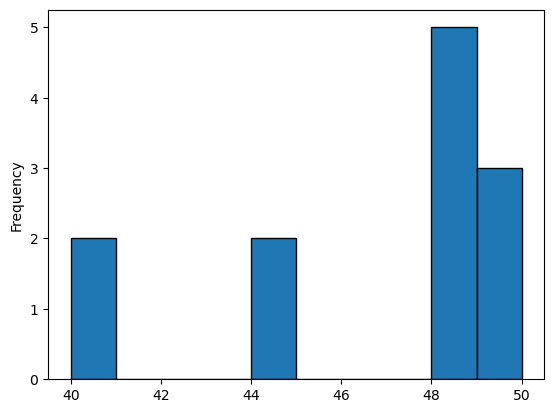

In [56]:
df_compare['taxi_high_income_percentage'] = round(df_compare['taxi_high_income']*100/df_compare['fe_cus_count'])
df_compare['taxi_high_income_percentage'].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Frequency'>

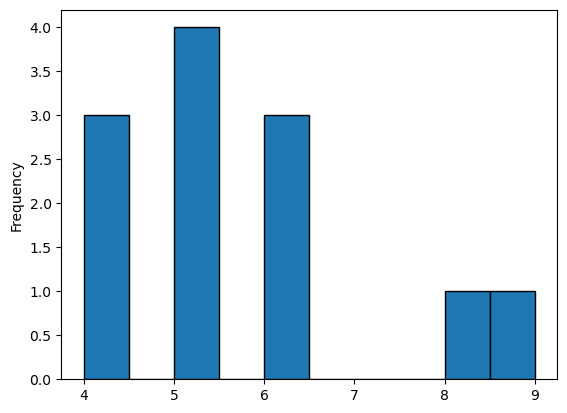

In [57]:
df_compare['link_only_service_percentage'] = round(df_compare['link_only_service']*100/df_compare['fe_cus_count'])
df_compare['link_only_service_percentage'].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Frequency'>

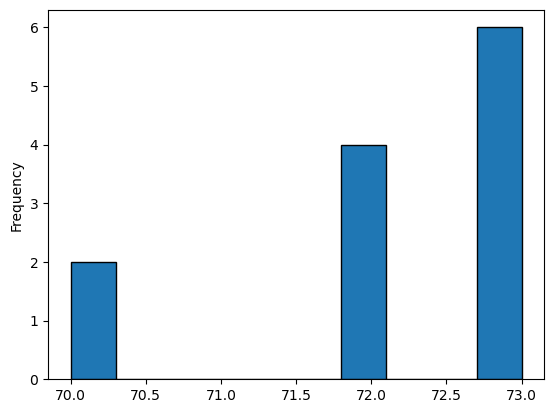

In [58]:
df_compare['both_service_percentage'] = round(df_compare['both_service']*100/df_compare['fe_cus_count'])
df_compare['both_service_percentage'].plot(kind='hist', edgecolor='black')

## All Hex 8

In [59]:
df_fee_affinity_data.head(2)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,customer_id,fare_estimate_id,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,20230710,Bangalore,Auto,Neelasandra,88618925a1fffff,59c3ea60eb41616737abc8a4,64ac044f9080515d7f54de2e,59c3ea60eb41616737abc8a4,NaN,NaN,NaN,NaN,59c3ea60eb41616737abc8a4,NaN,NaN,59c3ea60eb41616737abc8a4,NaN,NaN,59c3ea60eb41616737abc8a4,NaN
1,20230710,Bangalore,Auto,Venkatapura,8861892427fffff,63511b165a89f275af68cad7,64ac0279b54a0afcd9a77ff6,NaN,63511b165a89f275af68cad7,NaN,NaN,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN,63511b165a89f275af68cad7,NaN


In [60]:
df_oli_data.head(2)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
0,20230710,Bangalore,Link,Banashankri,88618924abfffff,64aba623dff66cdf7c5e35eb,1,1,0,0,0,1,1,0
1,20230710,Bangalore,Link,RTO Rajajinagar,8860145b1dfffff,64aba5744b17c450db8fe007,1,1,0,0,0,1,0,1


In [61]:
# Hex level agg

df_fee_aff_data_all_agg = df_fee_affinity_data \
                    .groupby(['city', 'service_name', 'pickup_cluster', 'pickup_hex_8']) \
                    .agg({'customer_id' : 'nunique', 'fare_estimate_id' : 'nunique',
                          'taxi_high_income' : 'nunique', 'taxi_medium_income' : 'nunique', 
                          'taxi_low_income' : 'nunique', 
                          'link_only_service' : 'nunique', 'auto_only_service' : 'nunique', 
                          'both_service' : 'nunique', 
                          'link_ps' : 'nunique', 'link_nps' : 'nunique', 
                          'auto_ps' : 'nunique', 'auto_nps' : 'nunique', 
                          'fe_intent_stable' : 'nunique', 'fe_intent_increasing' : 'nunique', 
                          'fe_intent_declining' : 'nunique'}) \
                    .reset_index() \
                    .sort_values(by='pickup_hex_8', ascending=False) \
                    .reset_index(drop=True)
df_fee_aff_data_all_agg.rename(columns = {'customer_id' : 'fe_cus_count', 
                                          'fare_estimate_id':'fe_count'}, inplace = True)
df_fee_aff_data_all_agg.head(5)

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,Bangalore,Auto,Hoskote_BLR,8861893893fffff,40,48,10,8,0,5,7,15,4,6,3,7,10,11,4
1,Bangalore,Link,Hoskote_BLR,8861893893fffff,40,48,10,8,0,5,7,15,4,6,3,7,10,11,4
2,Bangalore,Auto,Attibele,8861893713fffff,112,268,23,20,5,12,7,35,7,9,13,13,25,24,4
3,Bangalore,Link,Attibele,8861893713fffff,112,268,23,20,5,12,7,35,7,9,13,13,25,24,4
4,Bangalore,Auto,Attibele,88618936b5fffff,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0


In [62]:
df_oli_data_all_agg = df_oli_data \
                    .groupby(['city', 'service_name', 'pickup_hex_8']) \
                    .agg({'gross_orders' : 'sum', 
                          'requested_orders': 'sum', 
                          'cobrm':'sum', 
                          'expiry_mapped':'sum', 
                          'cobra':'sum', 
                          'accepted_orders':'sum', 
                          'ocara':'sum', 
                          'net_orders':'sum' }) \
                    .reset_index() \
                    .sort_values(by='pickup_hex_8', ascending=False) \
                    .reset_index(drop=True)

df_oli_data_all_agg['aor'] = round(df_oli_data_all_agg['accepted_orders']*100/df_oli_data_all_agg['requested_orders'])
#df_oli_data_all_agg.rename(columns = {'order_requested_order_id':'gross_orders', 'accepted_order_id':'accepted_orders', 'dropped_order_id':'dropped_orders' }, inplace = True)
df_oli_data_all_agg.head(5)

,city,service_name,pickup_hex_8,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,aor
0,Bangalore,Auto,8861896699fffff,1,1,1,0,0,0,0,0,0.0
1,Bangalore,Auto,886189389bfffff,1,1,1,0,0,0,0,0,0.0
2,Bangalore,Link,8861893893fffff,2,2,0,0,0,0,0,0,0.0
3,Bangalore,Auto,886189373bfffff,2,2,0,0,0,1,1,0,50.0
4,Bangalore,Auto,8861893737fffff,5,5,2,0,1,2,0,1,40.0


In [63]:
## All Hex 

df_compare_all = pd.merge(
                    df_fee_aff_data_all_agg, 
                    df_oli_data_all_agg,
                    how = 'inner',
                    left_on = ['city', 'service_name', 'pickup_hex_8'],
                    right_on = ['city', 'service_name', 'pickup_hex_8']
                    )
df_compare_all['fe2rr'] = round(df_compare_all['requested_orders']*100/df_compare_all['fe_count'])
df_compare_all['fe2net'] = round(df_compare_all['net_orders']*100/df_compare_all['fe_count'])
df_compare_all[df_compare_all['pickup_hex_8'].isin(['8860145959fffff'])]

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,...,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,aor,fe2rr,fe2net
3076,Bangalore,Auto,Yeshwanthpur,8860145959fffff,904,2875,317,235,59,78,...,728,0,49,121,565,101,308,78.0,25.0,11.0
3077,Bangalore,Link,Yeshwanthpur,8860145959fffff,904,2799,317,233,61,83,...,517,3,10,63,442,104,234,85.0,18.0,8.0


In [64]:
df_compare_all = df_compare_all[
                        ['city', 'service_name', 'pickup_cluster', 'pickup_hex_8',
                         'fe_cus_count', 'fe_count', 'requested_orders', 
                         'cobrm','expiry_mapped', 'cobra', 'accepted_orders', 'ocara', 
                         'net_orders', 'aor', 'fe2rr', 'fe2net',
                         'taxi_high_income', 'taxi_medium_income', 'taxi_low_income',
                         'link_only_service', 'auto_only_service', 'both_service',
                         'link_ps', 'link_nps', 
                         'auto_ps', 'auto_nps',
                         'fe_intent_stable', 'fe_intent_increasing', 'fe_intent_declining'
                        ]
                       ]

In [65]:
df_compare_all

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,requested_orders,cobrm,expiry_mapped,cobra,...,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,Bangalore,Link,Hoskote_BLR,8861893893fffff,40,48,2,0,0,0,...,5,7,15,4,6,3,7,10,11,4
1,Bangalore,Auto,Attibele,8861893713fffff,112,268,35,2,8,13,...,12,7,35,7,9,13,13,25,24,4
2,Bangalore,Link,Attibele,8861893713fffff,112,268,21,2,1,10,...,12,7,35,7,9,13,13,25,24,4
3,Bangalore,Link,Attibele,88618936a7fffff,4,22,2,0,0,2,...,1,0,2,0,0,0,1,1,2,0
4,Bangalore,Auto,Attibele,88618936a7fffff,4,23,5,2,0,0,...,1,0,2,0,0,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,Bangalore,Auto,Bidadi,8860144109fffff,39,73,46,0,0,2,...,0,35,4,0,0,0,0,19,13,0
4028,Bangalore,Auto,Bidadi,8860144107fffff,6,25,7,0,0,0,...,0,1,5,0,0,0,0,1,0,0
4029,Bangalore,Auto,Bidadi,8860144105fffff,17,57,32,0,0,0,...,0,16,1,0,0,0,0,16,0,0
4030,Bangalore,Auto,Bidadi,8860144101fffff,8,24,4,0,0,0,...,0,2,5,0,0,0,0,2,0,0


In [66]:
#df_compare_all.to_csv('hex_8_all_data_2023_07_10_to_16.csv', index=False)

In [67]:
# df_compare_all.describe()

In [68]:
df_compare_all

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,requested_orders,cobrm,expiry_mapped,cobra,...,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,Bangalore,Link,Hoskote_BLR,8861893893fffff,40,48,2,0,0,0,...,5,7,15,4,6,3,7,10,11,4
1,Bangalore,Auto,Attibele,8861893713fffff,112,268,35,2,8,13,...,12,7,35,7,9,13,13,25,24,4
2,Bangalore,Link,Attibele,8861893713fffff,112,268,21,2,1,10,...,12,7,35,7,9,13,13,25,24,4
3,Bangalore,Link,Attibele,88618936a7fffff,4,22,2,0,0,2,...,1,0,2,0,0,0,1,1,2,0
4,Bangalore,Auto,Attibele,88618936a7fffff,4,23,5,2,0,0,...,1,0,2,0,0,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,Bangalore,Auto,Bidadi,8860144109fffff,39,73,46,0,0,2,...,0,35,4,0,0,0,0,19,13,0
4028,Bangalore,Auto,Bidadi,8860144107fffff,6,25,7,0,0,0,...,0,1,5,0,0,0,0,1,0,0
4029,Bangalore,Auto,Bidadi,8860144105fffff,17,57,32,0,0,0,...,0,16,1,0,0,0,0,16,0,0
4030,Bangalore,Auto,Bidadi,8860144101fffff,8,24,4,0,0,0,...,0,2,5,0,0,0,0,2,0,0


<Axes: ylabel='Frequency'>

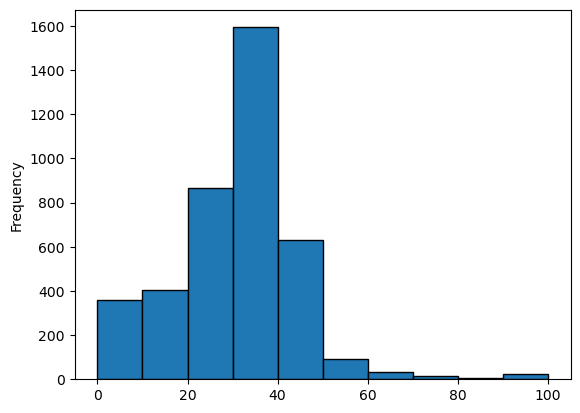

In [69]:
df_compare_all['taxi_high_income_percentage'] = round(df_compare_all['taxi_high_income']*100/df_compare_all['fe_cus_count'])
df_compare_all['taxi_high_income_percentage'].plot(kind='hist', edgecolor='black')

In [70]:
df_compare_all['taxi_high_income_percentage'].describe()

count    4032.000000
mean       30.282242
std        14.358479
min         0.000000
25%        23.000000
50%        32.000000
75%        38.000000
max       100.000000
Name: taxi_high_income_percentage, dtype: float64

<Axes: ylabel='Density'>

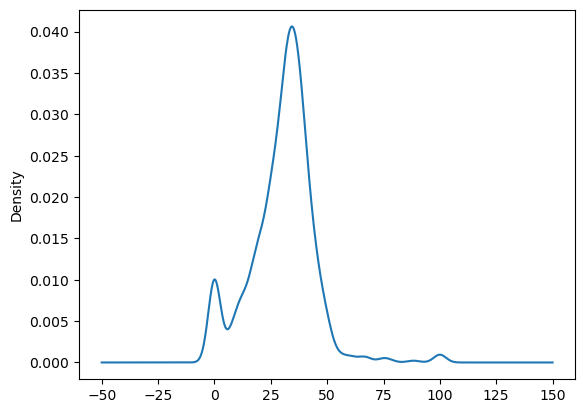

In [71]:
df_compare_all['taxi_high_income_percentage'].plot(kind='kde')

In [72]:
df_hsr = df_compare_all[df_compare_all['pickup_cluster'].isin(['CPWD Qtrs HSR','Hsr', 'HSR Sec 2', 'ITI Layout HSR', 'RTO HSR Sec 1'])]

In [73]:
df_Yeshwanthpur = df_compare_all[df_compare_all['pickup_cluster'].isin(['Metro - Yeshwantpur'])]

In [74]:
df_hsr['taxi_high_income_percentage'].describe()

count    12.000000
mean     46.416667
std       3.553701
min      40.000000
25%      44.000000
50%      48.000000
75%      48.250000
max      50.000000
Name: taxi_high_income_percentage, dtype: float64

In [46]:
df_Yeshwanthpur

,city,service_name,pickup_cluster,pickup_hex_8,fe_cus_count,fe_count,requested_orders,cobrm,expiry_mapped,cobra,...,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining,taxi_high_income_percentage
3072,Bangalore,Link,Metro - Yeshwantpur,886014595dfffff,7964,20954,2995,1,120,408,...,801,4114,842,1254,1091,1830,2725,2199,864,30.0
3073,Bangalore,Auto,Metro - Yeshwantpur,886014595dfffff,8047,21235,3799,4,328,678,...,843,4185,855,1270,1117,1880,2761,2234,882,30.0


In [75]:
df_Yeshwanthpur['taxi_high_income_percentage'].describe()

count     2.0
mean     30.0
std       0.0
min      30.0
25%      30.0
50%      30.0
75%      30.0
max      30.0
Name: taxi_high_income_percentage, dtype: float64

In [82]:
df_Yeshwanthpur['taxi_high_income_percentage'].unique()

array([30.])

<Axes: ylabel='Frequency'>

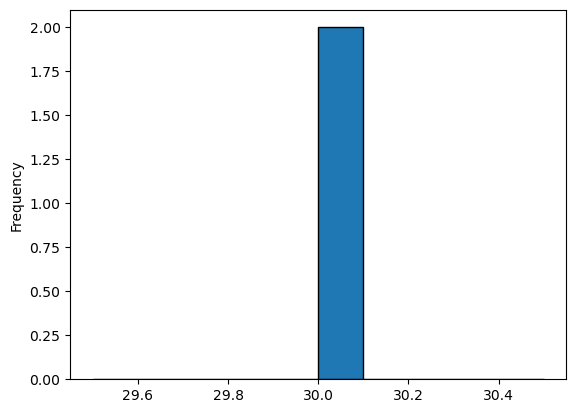

In [78]:
df_Yeshwanthpur['taxi_high_income_percentage'].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Density'>

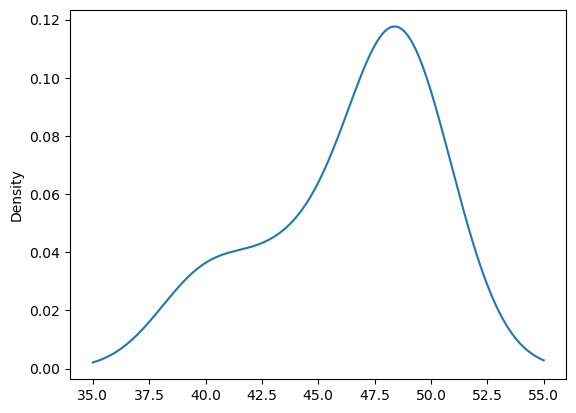

In [79]:
df_hsr['taxi_high_income_percentage'].plot(kind='kde')

<Axes: ylabel='Frequency'>

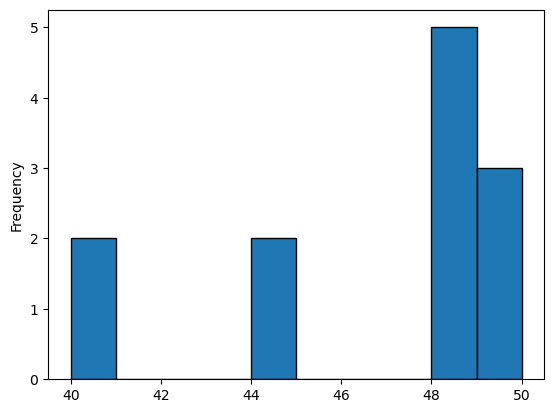

In [80]:
df_hsr['taxi_high_income_percentage'].plot(kind='hist', edgecolor='black')

In [81]:
df_hsr['taxi_high_income_percentage'].unique()

array([48., 49., 50., 44., 40.])